In [35]:
ditauPU = '/global/cfs/cdirs/m3443/data/TauStudies/v5/ditau_train.root'
qcdPU = '/global/cfs/cdirs/m3443/data/TauStudies/v5/qcd_train.root'
ditau_test = '/global/cfs/cdirs/m3443/data/TauStudies/v5/ditau_test_selections.root'
qcd_test = '/global/cfs/cdirs/m3443/data/TauStudies/v5/qcd_test_selections.root'
test = '/global/cfs/cdirs/m3443/data/TauStudies/v5/all_test.root'
allHighVarNames = ["JetCentralEFrac", "JetLeadingTrackFracP", "JetTrackR", 
                "JetMaxDRInCore", "JetNumISOTracks", "JetLeadingTrackD0",
                "JetTrackMass"]
highVarNames = ["JetLeadingTrackFracP", "JetTrackR", 
                "JetMaxDRInCore", "JetNumISOTracks", "JetTrackMass"]

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math
import networkx as nx
from root_gnn.src.datasets.tauid import TauIdentificationDataset
import tqdm

dataset = TauIdentificationDataset()

2022-07-18 15:11:34.446618: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/pe/papi/6.0.0.12/lib64:/opt/cray/job/2.2.4-7.0.3.1_3.17__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2020.2.254/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2020.2.254/linux/mkl/lib/intel64:/global/common/cori_cle7up03/software/darshan/3.3.1/lib
2022-07-18 15:11:34.446647: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Utility Functions

In [8]:
def get_num_track_tower(event):
    """
    Get the number of tracks and towers per jet in the event
    OUTPUT: a tuple (ntrack_per_jet, ntower_per_jet), where each element in it is an array of the number of tracks or towers, 
    with length = number of jets in the event
    """

    ntrack_per_jet = [event.JetGhostTrackN[indv_jet] for indv_jet in range(event.nJets)]
    ntower_per_jet = [event.JetTowerN[indv_jet] for indv_jet in range(event.nJets)]

    return ntrack_per_jet, ntower_per_jet

# Plots

In [47]:
def get_plotting_param(arr):
    weights = []
    for i in arr:
        weights.append(np.ones_like(i) / len(i))
        rg = [[min(i)-0.5, max(i)+0.5] for i in arr]
    
    rg_f = min([i[0] for i in rg]), max([i[1] for i in rg])
    bin_wid = 1
    num_bins = int((rg_f[1]-rg_f[0])/bin_wid)
    return weights, rg_f, num_bins

In [24]:
import math
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    if dphi > np.pi:
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi
    return dphi

def ori_get_info(chain, sig_only=False):
    signals = []
    d_all, z_all = [], []
    n_track, n_tower = [], []
    hlv_all = []
    track_idx = 0
    isTauEvent = len([i for i in chain.TruthJetIsTautagged if i > 0]) > 0
    for ijet in range(chain.nJets):
        # Filtering out reco jets
        d, z = [], []
        n_core_tracks = 0
        if chain.JetPt[ijet] < 30 or abs(chain.JetEta[ijet]) >= 3:
            signals.append(-1)
            d_all.append(d)
            z_all.append(z)
            hlv_all.append([])
            continue
        # Match jet to truth jet that minimizes angular distance
        split_point = 0
        nodes = []
        tower_nodes = []
        track_nodes = []
        min_index = 0
        if chain.nTruthJets > 0:
            min_dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[0])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[0])**2)
        for itruth in range(chain.nTruthJets):
            dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[itruth])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[itruth])**2)
            if dR < min_dR:
                min_dR = dR
                min_index = itruth
        if chain.nTruthJets > 0 and min_dR < 0.4:
            isTau = chain.TruthJetIsTautagged[min_index]
        else:
            isTau = 0
        #isTau = 0 if (isTau != 1 and isTau != 3) else isTau
        
        isTau = 0 if (isTau != 1 and isTau != 3) else isTau
        if sig_only and not isTau:
            continue
        elif (not isTau) and isTauEvent:
            continue
        """
        for itrack in range(chain.JetGhostTrackN[ijet]):
            ghost_track_idx = chain.JetGhostTrackIdx[track_idx]
            theta = 2*math.atan(-math.exp(chain.TrackEta[ghost_track_idx]))
            deta = chain.JetEta[ijet]-chain.TrackEta[ghost_track_idx]
            dphi = calc_dphi(chain.JetPhi[ijet],chain.TrackPhi[ghost_track_idx])
            dR = math.sqrt(dphi**2 + deta**2)
            if dR <= 0.2:
                n_core_tracks+=1
                
            z0 = math.log10(10e-3+math.fabs(chain.TrackZ0[ghost_track_idx]*math.sin(theta)))
            d0 = math.log10(10e-3+math.fabs(chain.TrackD0[ghost_track_idx]))
            d.append(d0)
            z.append(z0)
            track_idx+=1
        
        
        
        d_all.append(d)
        z_all.append(z)
        n_track.append(chain.JetGhostTrackN[ijet])
        n_tower.append(chain.JetTowerN[ijet])
        """
        signals.append(isTau)
        hlv_all.append([np.array(getattr(chain, hlv)[ijet], dtype=np.float32) for hlv in highVarNames])
        
    return signals, n_track, n_tower, d_all, z_all, hlv_all

In [11]:
import math
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    if dphi > np.pi:
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi
    return dphi

def get_info(chain, sig_only=False):
    signals = []
    d_all, z_all = [], []
    hlv_all = []
    track_idx = 0
    for ijet in range(chain.nJets):
        # Filtering out reco jets
        d, z = [], []
        n_core_tracks = 0
        if chain.JetPt[ijet] < 30 or abs(chain.JetEta[ijet]) >= 3:
            signals.append(-1)
            #d_all.append(d)
            #z_all.append(z)
            #hlv_all.append([])
            continue
        # Match jet to truth jet that minimizes angular distance
        split_point = 0
        nodes = []
        tower_nodes = []
        track_nodes = []
        min_index = 0
        if chain.nTruthJets > 0:
            min_dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[0])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[0])**2)
        for itruth in range(chain.nTruthJets):
            dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[itruth])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[itruth])**2)
            if dR < min_dR:
                min_dR = dR
                min_index = itruth
        if chain.nTruthJets > 0 and min_dR < 0.4:
            isTau = chain.TruthJetIsTautagged[min_index]
        else:
            isTau = 0
            
        if sig_only and not isTau:
            continue
        
        
        for itrack in range(chain.JetGhostTrackN[ijet]):
            ghost_track_idx = chain.JetGhostTrackIdx[track_idx]
            theta = 2*math.atan(-math.exp(chain.TrackEta[ghost_track_idx]))
            deta = chain.JetEta[ijet]-chain.TrackEta[ghost_track_idx]
            dphi = calc_dphi(chain.JetPhi[ijet],chain.TrackPhi[ghost_track_idx])
            dR = math.sqrt(dphi**2 + deta**2)
            if dR <= 0.2:
                n_core_tracks+=1
                
            #z0 = math.log10(10e-3+math.fabs(chain.TrackZ0[ghost_track_idx]*math.sin(theta)))
            #d0 = math.log10(10e-3+math.fabs(chain.TrackD0[ghost_track_idx]))
            #d.append(d0)
            #z.append(z0)
            track_idx+=1
        
        if isTau:
            if n_core_tracks == 0:
                signals.append(-2)
            else:
                signals.append(n_core_tracks)
        else:
            signals.append(isTau)
        #d_all.append(d)
        #z_all.append(z)
        #hlv_all.append([getattr(chain, hlv) for hlv in highVarNames])
        
    return signals

In [38]:
import tqdm
num_track = []
num_tower = []

isTau = []
ditau_nJets = []
qcd_nJets = []

d0 = []
z0 = []

hlv = []

nevt = 10000
evt = dataset.read(ditauPU, 0, nevt)
#bg = dataset.read(qcdPU, 0, nevt)


for _ in tqdm.trange(nevt, desc="ditau1"):
    f = next(evt)
    istau, n_track, n_tower, d, z, h = ori_get_info(f)
    isTau += istau
    num_track += n_track
    num_tower += n_tower
    d0 += d
    z0 += z
    hlv += h

ditau1: 100%|██████████| 10000/10000 [00:11<00:00, 867.83it/s]


In [16]:
total_jets = len(isTau)
#total_jets = len(num_track)
isTau = [i for i in isTau if i >= 0]
'''
assert total_jets == len(num_tower) == len(isTau)
n_tau_tracks_1p = [num_track[i] for i in range(total_jets) if isTau[i] == 1]
n_tau_tracks_3p = [num_track[i] for i in range(total_jets) if isTau[i] == 3]
n_qcd_tracks = [num_track[i] for i in range(total_jets) if isTau[i] == 0]
n_tau_towers_1p = [num_tower[i] for i in range(total_jets) if isTau[i] == 1]
n_tau_towers_3p = [num_tower[i] for i in range(total_jets) if isTau[i] == 3]
n_qcd_towers = [num_tower[i] for i in range(total_jets) if isTau[i] == 0]

total_jets = len(d0)
#filtered_out = sum([1 for i in isTau if i == -1])
'''
filtered_out = total_jets - len(num_track)
other_prong_jets = sum([1 for i in isTau if i > 1 and i != 3])

print(f'Total {total_jets} jets')
print(f'Filtered Out: {filtered_out} jets, {filtered_out/total_jets*100:.2f}%')
print(f'1-prong Tau Jets: {len(n_tau_tracks_1p)} jets, {len(n_tau_tracks_1p)/total_jets*100:.2f}%')
print(f'3-prong Tau Jets: {len(n_tau_tracks_3p)} jets, {len(n_tau_tracks_3p)/total_jets*100:.2f}%')
print(f'other-prong Tau Jets: {other_prong_jets} jets, {other_prong_jets/total_jets*100:.2f}%')
print(f'Non-tau Jets: {len(n_qcd_tracks)} jets, {len(n_qcd_tracks)/total_jets*100:.2f}%')

Total 2406 jets
Filtered Out: 2406 jets, 100.00%


NameError: name 'n_tau_tracks_1p' is not defined

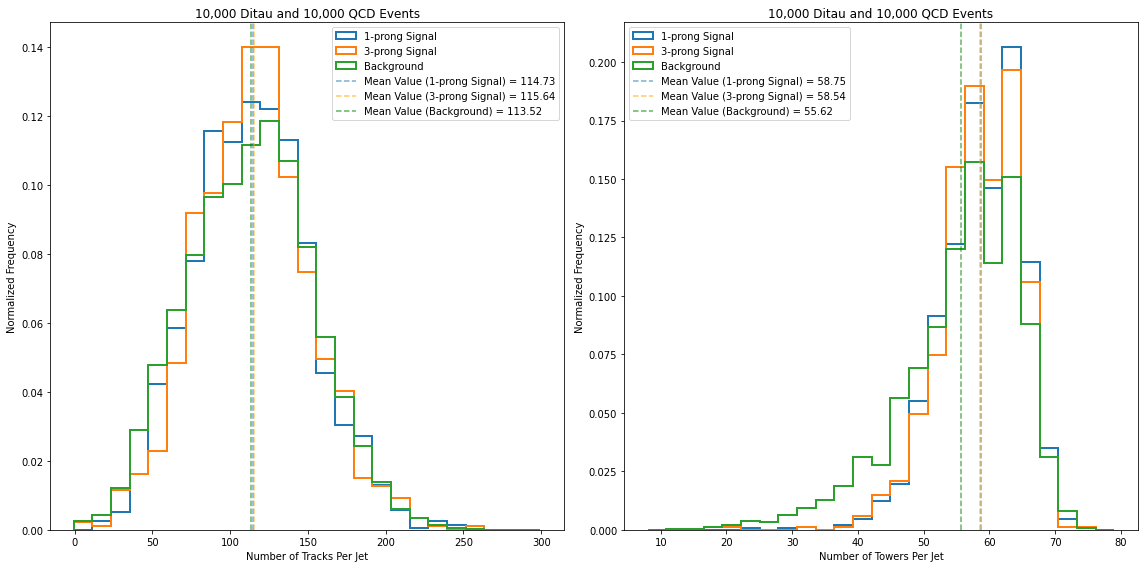

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(2*8,8))
weights, rg, num_bins = get_plotting_param([n_tau_tracks_1p, n_tau_tracks_3p, n_qcd_tracks])
ax[0].hist(n_tau_tracks_1p, range=(-0.5, 299.5), bins=25, weights=weights[0], align='mid', label='1-prong Signal', histtype='step', lw=2)
ax[0].hist(n_tau_tracks_3p, range=(-0.5, 299.5), bins=25, weights=weights[1], align='mid', label='3-prong Signal', histtype='step', lw=2)
ax[0].hist(n_qcd_tracks, range=(-0.5, 299.5), bins=25, weights=weights[2], align='mid', label='Background', histtype='step', lw=2)

n_tau_tracks_1p_avg = np.mean(n_tau_tracks_1p)
n_tau_tracks_3p_avg = np.mean(n_tau_tracks_3p)
n_qcd_tracks_avg = np.mean(n_qcd_tracks)
ax[0].axvline(n_tau_tracks_1p_avg, linestyle='dashed', alpha=0.6, label=f'Mean Value (1-prong Signal) = {n_tau_tracks_1p_avg:.2f}')
ax[0].axvline(n_tau_tracks_3p_avg, linestyle='dashed', alpha=0.6, color='orange', label=f'Mean Value (3-prong Signal) = {n_tau_tracks_3p_avg:.2f}')
ax[0].axvline(n_qcd_tracks_avg, linestyle='dashed', alpha=0.6, color='green', label=f'Mean Value (Background) = {n_qcd_tracks_avg:.2f}')

ax[0].set_title('10,000 Ditau and 10,000 QCD Events')
ax[0].set_ylabel('Normalized Frequency')
ax[0].set_xlabel('Number of Tracks Per Jet')
ax[0].legend()

weights, rg, num_bins = get_plotting_param([n_tau_towers_1p, n_tau_towers_3p, n_qcd_towers])
ax[1].hist(n_tau_towers_1p, range=rg, bins=25, weights=weights[0], align='mid', label='1-prong Signal', histtype='step', lw=2)
ax[1].hist(n_tau_towers_3p, range=rg, bins=25, weights=weights[1], align='mid', label='3-prong Signal', histtype='step', lw=2)
ax[1].hist(n_qcd_towers, range=rg, bins=25, weights=weights[2], align='mid', label='Background', histtype='step', lw=2)

n_tau_towers_1p_avg = np.mean(n_tau_towers_1p)
n_tau_towers_3p_avg = np.mean(n_tau_towers_3p)
n_qcd_towers_avg = np.mean(n_qcd_towers)
ax[1].axvline(n_tau_towers_1p_avg, linestyle='dashed', alpha=0.6, label=f'Mean Value (1-prong Signal) = {n_tau_towers_1p_avg:.2f}')
ax[1].axvline(n_tau_towers_3p_avg, linestyle='dashed', alpha=0.6, color='orange', label=f'Mean Value (3-prong Signal) = {n_tau_towers_3p_avg:.2f}')
ax[1].axvline(n_qcd_towers_avg, linestyle='dashed', alpha=0.6, color='green', label=f'Mean Value (Background) = {n_qcd_towers_avg:.2f}')

ax[1].set_title('10,000 Ditau and 10,000 QCD Events')
ax[1].set_ylabel('Normalized Frequency')
ax[1].set_xlabel('Number of Towers Per Jet')
ax[1].legend()

plt.tight_layout()

plt.savefig('Number_of_tracks_towers_10k.pdf')
plt.show()

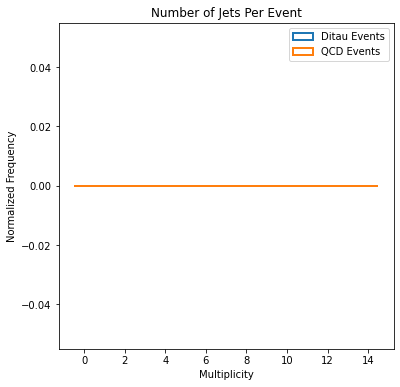

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
weights = np.ones_like(ditau_nJets) / len(ditau_nJets)
ax.hist(ditau_nJets, align='mid', bins=15, range=(-0.5, 14.5), weights=weights, histtype='step', lw=2, label=f'Ditau Events')
weights = np.ones_like(qcd_nJets) / len(qcd_nJets)
ax.hist(qcd_nJets, align='mid', bins=15, range=(-0.5, 14.5), weights=weights, histtype='step', lw=2, label=f'QCD Events')
ax.set_title(f'Number of Jets Per Event')
ax.set_ylabel('Normalized Frequency')
ax.set_xlabel("Multiplicity")
ax.legend()
plt.show()
plt.savefig('Number_of_jets.pdf')

In [19]:
tau_1p_d0 = []
tau_3p_d0 = []
non_tau_d0 = []
tau_z0 = []
non_tau_z0 = []

d0 = np.concatenate(d0, axis=None)
z0 = np.concatenate(z0, axis=None)

In [23]:
index = 0
for i in tqdm.trange(total_jets):
    n_track = num_track[i]
    if isTau[i] == 0:
        non_tau_d0.extend(d0[index:index+n_track])
        non_tau_z0.extend(z0[index:index+n_track])
    elif isTau[i] > 0:
        tau_d0.extend(d0[index:index+n_track])
        tau_z0.extend(z0[index:index+n_track])
    index += n_track

100%|██████████| 8361436/8361436 [02:12<00:00, 63154.40it/s] 


In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
weights, rg, num_bins = get_plotting_param([tau_d0, non_tau_d0])
ax[0].hist(tau_d0, range=rg, bins=num_bins, weights=weights[0], align='mid', label='Tau Jets', histtype='step', lw=2)
ax[0].hist(non_tau_d0, range=rg, bins=num_bins, weights=weights[1], align='mid', label='Non-Tau Jets', histtype='step', lw=2)

ax[0].set_title(r'Transverse Impact Parameter $d_0$')
ax[0].set_ylabel('Normalized Frequency')
ax[0].set_xlabel(r'Scaled $d_0$')
ax[0].legend()

weights, rg, num_bins = get_plotting_param([tau_z0, non_tau_z0])
ax[1].hist(tau_z0, range=rg, bins=num_bins, weights=weights[0], align='mid', label='Tau Jets', histtype='step', lw=2)
ax[1].hist(non_tau_z0, range=rg, bins=num_bins, weights=weights[1], align='mid', label='Non-Tau Jets', histtype='step', lw=2)

ax[1].set_title(r'Longitudinal Impact Parameter $z_0$')
ax[1].set_ylabel('Normalized Frequency')
ax[1].set_xlabel(r'Scaled $z_0$')
ax[1].legend()

plt.tight_layout()
plt.show()
plt.savefig('d0_z0.pdf')

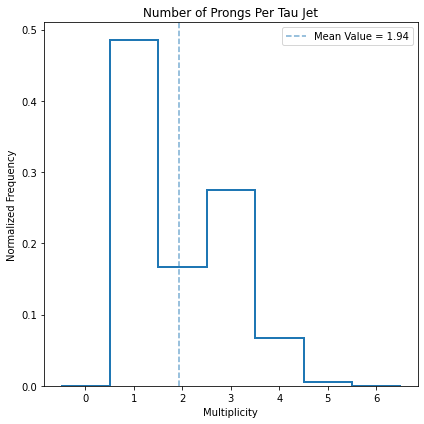

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
x = [i for i in isTau if i > 0]
weights, rg, num_bins = get_plotting_param([x])
ax.hist(x, range=(-0.5,6.5), bins=7, weights=weights[0], align='mid', histtype='step', lw=2)
x_avg = np.mean(x)
ax.axvline(x_avg, linestyle='dashed', alpha=0.6, label=f'Mean Value = {x_avg:.2f}')
ax.set_title('Number of Prongs Per Tau Jet')
ax.set_ylabel('Normalized Frequency')
ax.set_xlabel('Multiplicity')
ax.legend()
plt.tight_layout()

plt.savefig('Number_of_Prongs.pdf')
plt.show()

In [6]:
def calc_train_stats(chain, signal_only):
    n_sig_1p, n_sig_3p, n_filtered_sig, n_bg, n_filtered_bg = 0, 0, 0, 0, 0
    for ijet in range(chain.nJets):
        # Filtering out reco jets
        if chain.JetPt[ijet] < 30 or abs(chain.JetEta[ijet]) >= 3:
            n_filtered_bg += 1
            continue
        # Match jet to truth jet that minimizes angular distance
        min_index = 0
        if chain.nTruthJets > 0:
            min_dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[0])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[0])**2)
        for itruth in range(chain.nTruthJets):
            dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[itruth])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[itruth])**2)
            if dR < min_dR:
                min_dR = dR
                min_index = itruth
        if chain.nTruthJets > 0 and min_dR < 0.4:
            isTau = chain.TruthJetIsTautagged[min_index]
        else:
            isTau = 0
        if isTau == 1:
            n_sig_1p += 1
        elif isTau == 3:
            n_sig_3p += 1
        elif not isTau and signal_only:
            n_filtered_bg += 1
        elif not isTau and not signal_only:
            n_bg += 1
        else:
            n_filtered_sig += 1
    return np.array([n_sig_1p, n_sig_3p, n_filtered_sig, n_bg, n_filtered_bg], dtype=np.int8)

In [11]:
sig = dataset.read(ditauPU, 0, float('inf'))
bg = dataset.read(qcdPU, 0, float('inf'))

stats = np.array([0]*5)
for _ in tqdm.trange(dataset._num_evts(ditauPU), desc="ditau"):
    f = next(sig)
    stats += calc_train_stats(f, True)

for _ in tqdm.trange(dataset._num_evts(qcdPU), desc="qcd"):
    f = next(bg)
    stats += calc_train_stats(f, False)

qcd: 100%|██████████| 795177/795177 [18:39<00:00, 710.39it/s]


In [22]:
n_sig_1p, n_sig_3p, n_filtered_sig, n_bg, n_filtered_bg = list(stats)
tot_jets = sum(stats)
used_jets = n_sig_1p + n_sig_3p + n_bg
print(f"Total Number of Jets: {tot_jets}, Used: {used_jets} ({used_jets/tot_jets*100:.2f}%) Jets")
print(f"  Filtered out {n_filtered_sig} ({n_filtered_sig/(n_sig_1p + n_sig_3p + n_filtered_sig)*100:.2f}%) Signals and {n_filtered_bg} ({n_filtered_bg/(n_filtered_bg+n_bg)*100:.2f}%) Backgrounds")
print(f"Signal-Background Ratio: ")
print(f"  1-prong: {n_sig_1p} jets, 1:{n_bg/n_sig_1p:.2f} \n  3-prong: {n_sig_3p} jets, 1:{n_bg/n_sig_3p:.2f}")
print(f"  Inclusive: {n_sig_1p+n_sig_3p} jets, 1:{n_bg/(n_sig_1p+n_sig_3p):.2f}")
print(f"  Total Background Jets: {n_bg} ({n_bg/used_jets*100:.2f}%)")

Total Number of Jets: 8295477, Used: 3011682 (36.31%) Jets
  Filtered out 64901 (23.75%) Signals and 5218894 (65.06%) Backgrounds
Signal-Background Ratio: 
  1-prong: 133780 jets, 1:20.95 
  3-prong: 74570 jets, 1:37.59
  Inclusive: 208350 jets, 1:13.45
  Total Background Jets: 2803332 (93.08%)


In [27]:
import random
random.seed(12345)
print("Using only 50% of the background jets to achieve a signal-background ratio of approximately 1:6")
n_bg_final = n_bg - sum([1 for _ in range(n_bg) if random.random() > 0.5])
print("Final Signal-Background Ratio: ")
print(f"  1-prong: {n_sig_1p} jets, 1:{n_bg_final/n_sig_1p:.2f} \n  3-prong: {n_sig_3p} jets, 1:{n_bg_final/n_sig_3p:.2f}")
print(f"  Inclusive: {n_sig_1p+n_sig_3p} jets, 1:{n_bg_final/(n_sig_1p+n_sig_3p):.2f}")
n_sig_train = int((n_sig_1p+n_sig_3p)*0.8)
n_bg_train = int(n_bg_final*0.8)
print(f"  Total Background Jets: {n_bg_final} ({n_bg_final/(n_sig_1p+n_sig_3p+n_bg_final)*100:.2f}%)")
print(f"Final Training Dataset: ")
print(f"  Signal (Inclusive): {n_sig_train} jets, Background: {n_bg_train} jets, Total: {n_sig_train+n_bg_train} jets")

Using only 50% of the background jets to achieve a signal-background ratio of approximately 1:6
Final Signal-Background Ratio: 
  1-prong: 133780 jets, 1:10.47 
  3-prong: 74570 jets, 1:18.78
  Inclusive: 208350 jets, 1:6.72
  Total Background Jets: 1400484 (87.05%)
Final Training Dataset: 
  Signal (Inclusive): 166680 jets, Background: 1120387 jets, Total: 1287067 jets


In [41]:
total_jets = len(isTau)
hlv_1p = [hlv[i] for i in range(total_jets) if len(hlv[i]) != 0 and isTau[i] == 1]
hlv_3p = [hlv[i] for i in range(total_jets) if len(hlv[i]) != 0 and isTau[i] == 3]
hlv_bg = [hlv[i] for i in range(total_jets) if len(hlv[i]) != 0 and isTau[i] == 0]

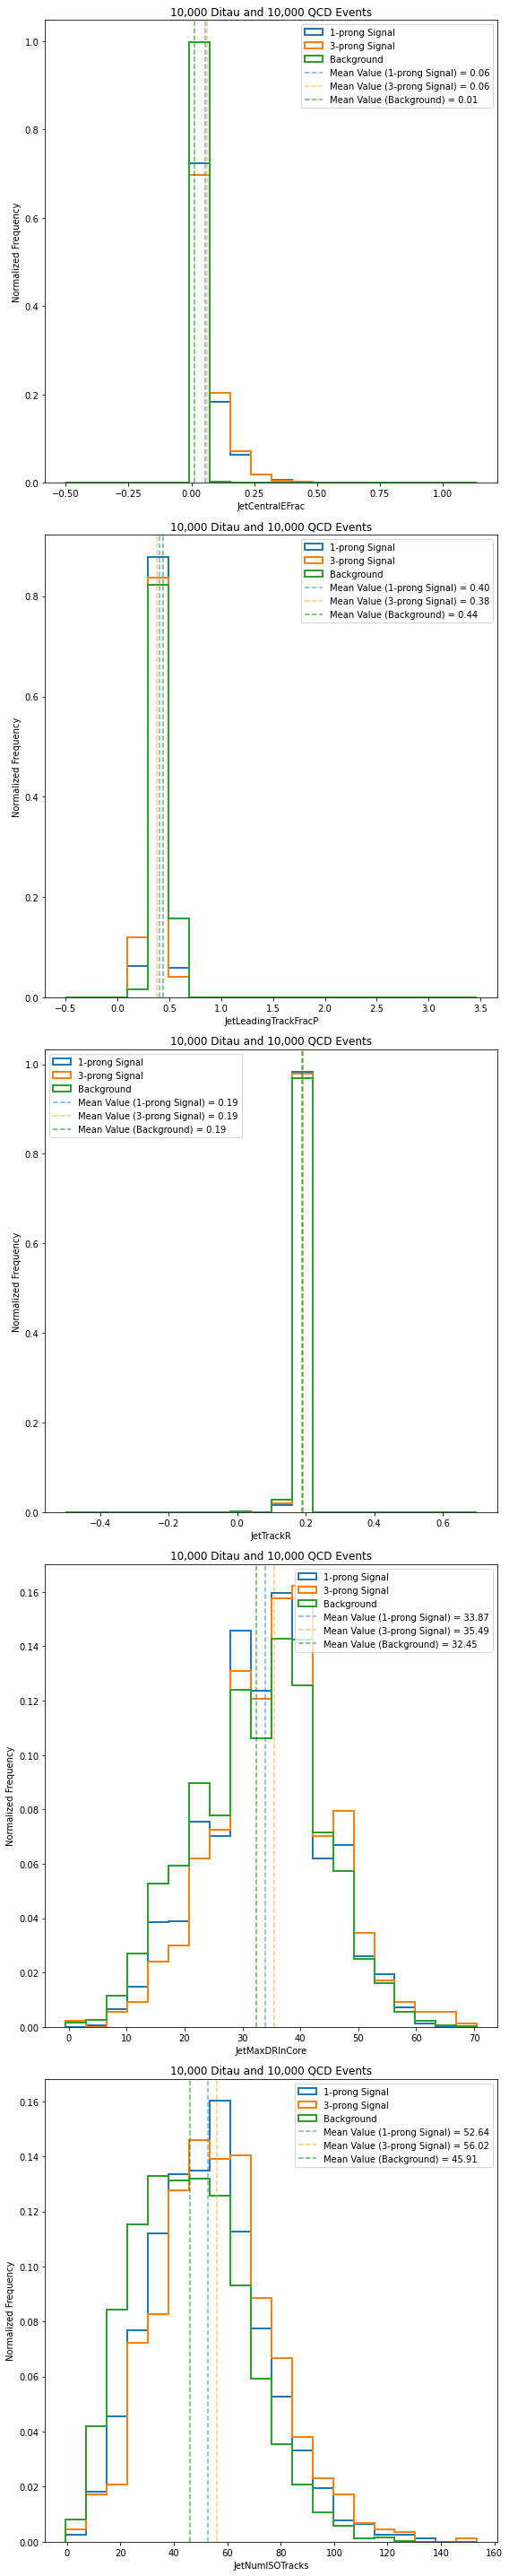

In [45]:
ngraph = len(highVarNames)
fig, ax = plt.subplots(nrows=ngraph, figsize=(8,8*ngraph))

for i in range(ngraph):
    sig1 = [float(s[i]) for s in hlv_1p if len(s) != 0]
    sig3 = [float(s[i]) for s in hlv_3p if len(s) != 0]
    bg = [float(s[i]) for s in hlv_bg if len(s) != 0]
    weights, rg, num_bins = get_plotting_param([sig1, sig3, bg])
    ax[i].hist(sig1, range=rg, bins=20, weights=weights[0], align='mid', label='1-prong Signal', histtype='step', lw=2)
    ax[i].hist(sig3, range=rg, bins=20, weights=weights[1], align='mid', label='3-prong Signal', histtype='step', lw=2)
    ax[i].hist(bg, range=rg, bins=20, weights=weights[2], align='mid', label='Background', histtype='step', lw=2)

    n_tau_tracks_1p_avg = np.mean(sig1)
    n_tau_tracks_3p_avg = np.mean(sig3)
    n_qcd_tracks_avg = np.mean(bg)
    ax[i].axvline(n_tau_tracks_1p_avg, linestyle='dashed', alpha=0.6, label=f'Mean Value (1-prong Signal) = {n_tau_tracks_1p_avg:.2f}')
    ax[i].axvline(n_tau_tracks_3p_avg, linestyle='dashed', alpha=0.6, color='orange', label=f'Mean Value (3-prong Signal) = {n_tau_tracks_3p_avg:.2f}')
    ax[i].axvline(n_qcd_tracks_avg, linestyle='dashed', alpha=0.6, color='green', label=f'Mean Value (Background) = {n_qcd_tracks_avg:.2f}')

    ax[i].set_title('10,000 Ditau and 10,000 QCD Events')
    ax[i].set_ylabel('Normalized Frequency')
    ax[i].set_xlabel(allHighVarNames[i])
    ax[i].legend()


plt.tight_layout()

plt.savefig('Hlv.pdf')
plt.show()